In [1]:
from pprint import pprint
from convertmol import parse_sdf_file, bond_type_dict, single_bond_stereo_dict, double_bond_stereo_dict
from torch_geometric.data import Data
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
import sascorer
torch.set_default_device('cpu:0')#'cuda'

In [2]:
from neo4j import GraphDatabase, RoutingControl


URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

In [3]:
from neo4j import Transaction, ManagedTransaction
def iterate_from_source_batched(tx: ManagedTransaction, name: str, batch_size):
    assert isinstance(batch_size, int)
    assert batch_size>0
    query = f"""
    MATCH (m:Molecule)-[:PART_OF]->(s:Source {{name: $name}})
    MATCH (a:Atom)-[:PART_OF]->(m)
    OPTIONAL MATCH (a)-[b:BOND]->(c:Atom)
    RETURN m, a, b, c
    """
    ready_mols=[]
    mol_buffer={}
    for record in tx.run(query,{"name":name}):
        #print('record')
        m = record["m"]
        a = record["a"]
        b = record.get("b",None)
        c = record.get("c",None)

        aIdx=a['Idx']
        bIdx=None
        cIdx=None
        if b:
            bIdx=b['Idx']
        if c:
            cIdx=c['Idx']
        _Name = m['_Name']

        if _Name not in mol_buffer:
            # Initialize molecule entry
            mol_buffer[_Name] = {
                "molecule": m,
                "atoms": {
                    aIdx:a,
                },
                "bonds": {}
            }
                    
            if b:
                mol_buffer[_Name]['bonds'][bIdx]=b
            if c:
                mol_buffer[_Name]['atoms'][cIdx]=c
                
        elif mol_buffer[_Name] != True: #if it's true, it means that it's already been yielded
            if aIdx not in mol_buffer[_Name]['atoms']:
                mol_buffer[_Name]['atoms'][aIdx]=a
            if bIdx and bIdx not in mol_buffer[_Name]['bonds']:
                mol_buffer[_Name]['bonds'][bIdx]=b
            if cIdx and cIdx not in mol_buffer[_Name]['atoms']:
                mol_buffer[_Name]['atoms'][cIdx]=c
        else:
            continue
        if len(mol_buffer[_Name]['atoms'])==m['NumAtoms'] and len(mol_buffer[_Name]['bonds'])==m['NumBonds']:
            #print("appending molecule",_Name,len(mol_buffer[_Name]['atoms']),len(mol_buffer[_Name]['bonds']))
            ready_mols.append(mol_buffer[_Name])
            mol_buffer[_Name]=True
            if len(ready_mols)>=batch_size:
                yield ready_mols
                ready_mols.clear()
    for k,v in mol_buffer.items():
        if v != True:
            ready_mols.append(v)
    if len(ready_mols)>0:
        yield ready_mols

In [4]:
from neo4j import Transaction, ManagedTransaction
def stream_from_source(tx: ManagedTransaction, name: str):
    query = f"""
    MATCH (m:Molecule)-[:PART_OF]->(s:Source {{name: $name}})
    MATCH (a:Atom)-[:PART_OF]->(m)
    OPTIONAL MATCH (a)-[b:BOND]->(c:Atom)
    RETURN m, a, b, c
    """
    mol_buffer=dict()
    for record in tx.run(query,{"name":name}):
        #print('record',record['m']['_Name'])
        m = record["m"]
        a = record["a"]
        b = record.get("b",None)
        c = record.get("c",None)

        aIdx=a['Idx']
        bIdx=None
        cIdx=None
        if b:
            bIdx=b['Idx']
        if c:
            cIdx=c['Idx']
        _Name = m['_Name']

        if _Name not in mol_buffer:
            # Initialize molecule entry
            mol_buffer[_Name] = dict({
                "molecule": m,
                "atoms": dict({
                    aIdx:a,
                }),
                "bonds": dict()
            })
                    
            if b:
                mol_buffer[_Name]['bonds'][bIdx]=b
            if c:
                mol_buffer[_Name]['atoms'][cIdx]=c
                
        elif mol_buffer[_Name] != True: #if it's true, it means that it's already been yielded
            if aIdx not in mol_buffer[_Name]['atoms']:
                mol_buffer[_Name]['atoms'][aIdx]=a
            if bIdx and bIdx not in mol_buffer[_Name]['bonds']:
                mol_buffer[_Name]['bonds'][bIdx]=b
            if cIdx and cIdx not in mol_buffer[_Name]['atoms']:
                mol_buffer[_Name]['atoms'][cIdx]=c
        else:
            continue
        if len(mol_buffer[_Name]['atoms'])==m['NumAtoms'] and len(mol_buffer[_Name]['bonds'])==m['NumBonds']:
            #print("yielding molecule",_Name,len(mol_buffer[_Name]['atoms']),len(mol_buffer[_Name]['bonds']))
            tmp = (mol_buffer[_Name])
            atoms=tmp['atoms']
            atoms=[atoms[i] for i in atoms]
            bonds=tmp['bonds']
            bonds=[bonds[i] for i in bonds]
            yield atoms, bonds, tmp['molecule']
            mol_buffer[_Name]=True
    for k,v in mol_buffer.items():
        if v != True:
            atoms=v['atoms']
            atoms=[atoms[i] for i in atoms]
            bonds=v['bonds']
            bonds=[bonds[i] for i in bonds]
            #print("yielding molecule",v['_Name'],len(v['atoms']),len(v['bonds']))
            yield atoms, bonds, v['molecule']

In [5]:
ATOMIC_SYMBOL = {
    'H':0, 'He': 1, 'Li': 2, 'Be': 3, 'B': 4, 'C': 5, 'N': 6, 'O': 7, 'F': 8, 'Ne': 9, 
    'Na': 10, 'Mg': 11, 'Al': 12, 'Si': 13, 'P': 14, 'S': 15, 'Cl': 16, 'Ar': 17, 
    'K': 18, 'Ca': 19, 'Sc': 20, 'Ti': 21, 'V': 22, 'Cr': 23, 'Mn': 24, 'Fe': 25, 
    'Co': 26, 'Ni': 27, 'Cu': 28, 'Zn': 29, 'Ga': 30, 'Ge': 31, 'As': 32, 'Se': 33, 
    'Br': 34, 'Kr': 35, 'Rb': 36, 'Sr': 37, 'Y': 38, 'Zr': 39, 'Nb': 40, 'Mo': 41, 
    'Tc': 42, 'Ru': 43, 'Rh': 44, 'Pd': 45, 'Ag': 46, 'Cd': 47, 'In': 48, 'Sn': 49, 
    'Sb': 50, 'Te': 51, 'I': 52, 'Xe': 53, 'Cs': 54, 'Ba': 55, 'La': 56, 'Ce': 57, 
    'Pr': 58, 'Nd': 59, 'Pm': 60, 'Sm': 61, 'Eu': 62, 'Gd': 63, 'Tb': 64, 'Dy': 65, 
    'Ho': 66, 'Er': 67, 'Tm': 68, 'Yb': 69, 'Lu': 70, 'Hf': 71, 'Ta': 72, 'W ': 73, 
    'Re': 74, 'Os': 75, 'Ir': 76, 'Pt': 77, 'Au': 78, 'Hg': 79, 'Tl': 80, 'Pb': 81, 
    'Bi': 82, 'Po': 83, 'At': 84, 'Rn': 85, 'Fr': 86, 'Ra': 87, 'Ac': 88, 'Th': 89, 
    'Pa': 90, 'U': 91, 'Np': 92, 'Pu': 93, 'Am': 94, 'Cm': 95, 'Bk': 96, 'Cf': 97, 
    'Es': 98, 'Fm': 99, 'Md': 100, 'No': 101, 'Lr': 102, 'Rf': 103, 'Db': 104, 'Sg': 105, 
    'Bh': 106, 'Hs': 107, 'Mt': 108, 'Ds': 109, 'Rg': 110, 'Cn': 111, 'Nh': 112, 'Fl': 113, 
    'Mc': 114, 'Lv': 115, 'Ts': 116, 'Og': 117
}

In [6]:
BONDTYPE= {
    'UNSPECIFIED': 0,
    'SINGLE': 1,
    'DOUBLE': 2,
    'TRIPLE': 3,
    'QUADRUPLE': 4,
    'QUINTUPLE': 5,
    'HEXTUPLE': 6,
    'ONEANDAHALF': 7,
    'TWOANDAHALF': 8,
    'THREEANDAHALF': 9,
    'FOURANDAHALF': 10,
    'FIVEANDAHALF': 11,
    'AROMATIC': 12,
    'IONIC': 13,
    'HYDROGEN': 14,
    'THREECENTER': 15,
    'DATIVEONE': 16,
    'DATIVE': 17,
    'DATIVEL': 18,
    'DATIVER': 19,
    'OTHER': 20,
    'ZERO': 21,
}

In [7]:
def atoms_transform_get_symbol(atoms, x): #should we use X&x or x&x_?
    return atoms, ([(
        *x_, ATOMIC_SYMBOL[atom['Symbol']]
    ) for x_,atom in zip(x,atoms)])

In [8]:
def bonds_transform_get_bondtype(bonds, edge_index, edge_attr):
    return bonds, edge_index, ([(
        *edge_attr_, BONDTYPE[bond['BondType']]
    ) for edge_attr_,bond in zip(edge_attr, bonds)])

In [9]:
def bonds_transform_get_edge_index(bonds, edge_index, edge_attr):
    return bonds, ([(
        *edge_index_, bond['BeginAtomIdx'], bond['EndAtomIdx']
    ) for edge_index_,bond in zip(edge_index, bonds)]), edge_attr

In [10]:
def bonds_transform_add_mirrored_edge_index_and_attr(bonds, edge_index, edge_attr):
    return bonds, tuple(sum([edge_index, [ei[::-1] for ei in edge_index]], [])), tuple(sum([edge_attr, edge_attr], []))

In [11]:
def bonds_transform_transpose_edge_index(bonds, edge_index, edge_attr):
    return bonds, tuple(zip(*edge_index)), edge_attr

In [12]:
def bonds_transform_flatten_edge_attr(bonds, edge_index, edge_attr):
    return bonds, edge_index, tuple(sum((list(ei) for ei in edge_attr),[]))

In [13]:
def atoms_transform_flatten_x(atoms, x):
    return atoms, tuple(sum((list(x_) for x_ in x),[]))

In [14]:
def mol_transform_get_prop(key):
    def inner(mol, y):
        y = (*y, mol[key])
        return mol, y
    return inner

In [15]:
from torch_geometric.data import Data
def mol_to_data(atoms, bonds, mol, atom_transformations, bond_transformations, mol_transformations=None):
    #print('mol_to_data',len(atoms), len(bonds), mol['_Name'])
    #print("mol...")
    #display(mol)
    x=tuple(tuple() for _ in range(len(atoms)))
    for t in atom_transformations:
        atoms, x = t(atoms, x)
    
    edge_index=tuple(tuple() for _ in range(len(bonds)))
    edge_attr=tuple(tuple() for _ in range(len(bonds)))
    for t in bond_transformations:
        bonds, edge_index, edge_attr = t(bonds, edge_index, edge_attr)

    if mol_transformations:
        y=()
        for t in mol_transformations:
            mol, y = t(mol, y)
        #print("y...")
        #display(y)
        return Data(x=torch.tensor(x), edge_attr=torch.tensor(edge_attr), edge_index=torch.tensor(edge_index), y=torch.tensor(y))
    return Data(x=torch.tensor(x), edge_attr=torch.tensor(edge_attr), edge_index=torch.tensor(edge_index))

In [16]:
def mols_to_data(abm_gen, atom_transformations, bond_transformations, mol_transformations=None):
    #print("START mols_to_data")
    for atoms, bonds, mol in abm_gen:
        tmp = mol_to_data(atoms, bonds, mol, atom_transformations, bond_transformations, mol_transformations=mol_transformations)
        #print("yield",tmp)
        yield tmp
    #print("END mols_to_data")

GCN=$\sigma(AXW)$

RGCN=$\sum_{r \in R}(AXW_r)$

In [17]:
from torch_geometric.nn.conv import RGCNConv

class RGCNLayer(nn.Module):
    'https://arxiv.org/pdf/1703.06103'
    def __init__(self, in_dim, out_dim, do_rate, activation=nn.Tanh):
        super().__init__()
        self.inner = RGCNConv(in_dim, out_dim, len(BONDTYPE))
        self.do = nn.Dropout(p=do_rate)
        self.act = activation() if activation is not None else None
    def forward(self, 
                data, 
                use_old=False
                #inputs = (X,A) 
                #X: (B*, N, in_dim) ; x_v^{(l)} synonymous with h_v^{(l)}
                #A: (B*, num_relations, N, N)
               ):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_attr
        x=self.inner(x,edge_index,edge_type)
        if self.act is not None:
            data = self.act(x)
        x=self.do(x)
        return Data(x=x,edge_index=edge_index, edge_attr=edge_type)
        
class RGCN(nn.Module):
    def __init__(self, input_dim, dims, output_dim, activation=nn.Tanh, final_activation=nn.Tanh, dropout_rate=0.0):
        super().__init__()
        self.node_emb=nn.Embedding(len(ATOMIC_SYMBOL), input_dim)
        self.dims=[input_dim]+dims+[output_dim]
        self.do_rate=dropout_rate
        self.layers = nn.Sequential(
            *[
                x
                for xs in [(
                    RGCNLayer(self.dims[i],self.dims[i+1], activation=activation, do_rate=self.do_rate),
                ) if i+1<len(self.dims)-1 else (
                    RGCNLayer(self.dims[i],self.dims[i+1], activation=final_activation, do_rate=self.do_rate),
                ) if final_activation is not None else (
                    RGCNLayer(self.dims[i],self.dims[i+1], activation=None, do_rate=self.do_rate),
                )  for i in range(len(self.dims)-1)]
                for x in xs
            ]
        )
    def forward(self, x):
        x=x.clone()
        x.x=self.node_emb(x.x)
        return self.layers(x)

In [59]:
class EpochedStream:
    def __init__(self, gen, max_epochs):
        self.gen=gen
        self.max_epochs=max_epochs
        self.epoch=0
        self.n=-1
        self.i=0
        self.saves=list()
    def __iter__(self):
        return self
    def __next__(self):
        if self.epoch==0:
            try:
                self.n+=1
                nxt = next(self.gen)
                self.saves.append(None)
                self.saves[self.n]=nxt
                return nxt
            except:
                self.epoch+=1
        if self.i>=self.n:
            self.i=0
            self.epoch+=1
        if self.epoch>=self.max_epochs:
            raise StopIteration
        self.i+=1
        return self.saves[self.i-1]

In [19]:
from abc import ABC,abstractmethod
class Task(ABC):
    def __init__(self, atom_transformations, bond_transformations, mol_transformations=None):
        self.atom_transformations=atom_transformations
        self.bond_transformations=bond_transformations
        self.mol_transformations=mol_transformations
    @abstractmethod
    def train(self, model, abm_gen, epochs):
        pass
    @abstractmethod
    def eval(self, model, abm_gen):
        pass

In [20]:
from tqdm.auto import tqdm
class PlogpRegressionTask(Task):
    def __init__(self):
        super().__init__(
            (
                atoms_transform_get_symbol, 
                atoms_transform_flatten_x # 
            ), 
            (
                bonds_transform_get_bondtype, 
                bonds_transform_get_edge_index, 
                bonds_transform_add_mirrored_edge_index_and_attr, 
                bonds_transform_transpose_edge_index, #
                bonds_transform_flatten_edge_attr #
            ),
            (
                mol_transform_get_prop("plogp"),
            )
        )
    def train(self, model: nn.Module, abm_gen, epochs=1):
        optimizer=torch.optim.AdamW(model.parameters())
        MAE=0.0
        n=100
        iterator = tqdm(EpochedStream(
            mols_to_data(
                abm_gen, 
                self.atom_transformations, 
                self.bond_transformations,
                self.mol_transformations
            ),
            max_epochs=epochs
        ))
        for data in iterator:
            output=model(data)
            pred=output.x.mean()
            error=(pred-data.y)**2
            error.backward()
            optimizer.step()
            model.zero_grad(set_to_none=True)
            MAE=(1-1/n)*MAE+error.detach().cpu().item()
            iterator.set_description(f"SSE: {MAE:.2f}")
    def eval(self, model, abm_gen):
        pred=[]
        target=[]
        with torch.no_grad():
            iterator = tqdm(mols_to_data(
                    abm_gen, 
                    self.atom_transformations, 
                    self.bond_transformations,
                    self.mol_transformations
            ))
            for data in iterator:
                output=model(data)
                pred.append(output.x.mean())
                target.append(data.y)
        return pred, target

In [90]:
from neo4j import READ_ACCESS
task=PlogpRegressionTask()
model,name=rgcn_create_if_new("model1")
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session(default_access_mode=READ_ACCESS) as session:
        with session.begin_transaction() as tx:
            gen1=stream_from_source(tx, "zinc_250k_10k.csv")
            gen2=stream_from_source(tx, "zinc_250k_10k.csv")
            task.train(model, gen1, epochs=1)
            pred, target=task.eval(model, gen2)
            save_model(model,name)

ERROR failed to load model


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [93]:
model2,name=rgcn_create_if_new("model1")
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    with driver.session(default_access_mode=READ_ACCESS) as session:
        with session.begin_transaction() as tx:
            gen2=stream_from_source(tx, "zinc_250k_10k.csv")
            pred, target=task.eval(model2, gen2)

0it [00:00, ?it/s]

In [81]:
import json
import re
pat=re.compile(r'[A-Za-z0-9_\-\\]+$', re.UNICODE)

def input_cast(prompt, cast, error_message="something went wrong..."):
    try_again=True
    while try_again:    
        try:
            return cast(input(prompt))
        except:
            print(error_message)

def rgcn_ask_for_config(name=None, input_size=None, output_size=None):
    if name==None:
        name = input("directory name for the model")

    while not pat.match(name):
        print("the name for the model must be a valid directory name")
        name = input("filename for the model")

    if input_size == None:
        input_size = input_cast("input size (unsigned integer):", int)

    hidden_dims=[]
    next_hd = input_cast("next hidden size (0 when done):", int)
    while next_hd!=0:
        hidden_dims.append(next_hd)
        next_hd = input_cast("next hidden size (0 when done):", int)

    if output_size == None:
        output_size = input_cast("output size (unsigned integer):", int)

    if not os.path.exists(f'models/{name}'):
        os.makedirs(f'models/{name}')
        with open(f"models/{name}/arch.json", "w") as f:
            json.dump({
                "input_size":input_size,
                "hidden_dims":hidden_dims,
                "output_size":output_size
            }, f)
    model=RGCN(input_size, hidden_dims, output_size)
    return model, name

In [82]:
def rgcn_ask_from_config(name=None):
    if name==None:
        name = input("directory name for the model")

    while not pat.match(name):
        print("the name for the model must be a valid directory name")
        name = input("filename for the model")
        
    return rgcn_ask_from_config(name)

In [83]:
def rgcn_create_if_new(name=None):
    if name==None:
        name = input("directory name for the model")

    while not pat.match(name):
        print("the name for the model must be a valid directory name")
        name = input("filename for the model")

    if not os.path.exists(f'models/{name}'):
        return rgcn_ask_for_config(name=name)

    return rgcn_from_config(name)

In [89]:
def rgcn_from_config(name):
    with open(f"models/{name}/arch.json", "r") as f:
        data=json.load(f)
        
    model = RGCN(data['input_size'],data['hidden_dims'],data['output_size'])
    
    try:
        model.load_state_dict(torch.load(f"models/{name}/state_dict.pth", weights_only=True))
    except:
        print("ERROR failed to load model")
    return model, name

In [80]:
def save_model(model, name):
    torch.save(model.state_dict(), f"models/{name}/state_dict.pth")

In [ ]:
tasks={
    "PlogP Regression":PlogpRegressionTask,
}
models={
    "RGCN":rgcn_create_if_new
}

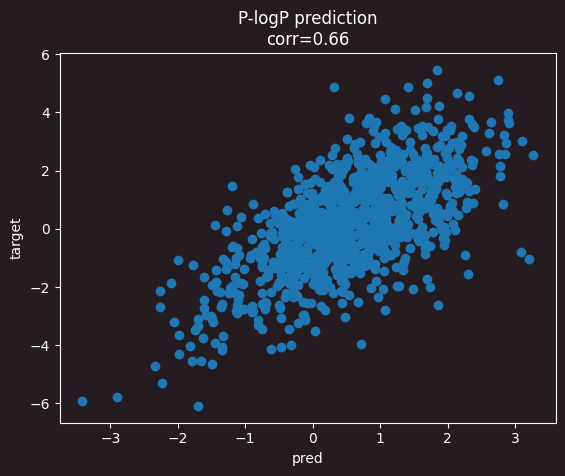

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(pred,target)
ax.set_xlabel("pred",c='white')
ax.set_ylabel("target",c='white')
ax.set_title(f"P-logP prediction\ncorr={pd.DataFrame({'pred':pred,'target':target}).corr()['pred']['target']:.2f}",c='white')
ax.set_facecolor((0.14, 0.11, 0.125))

ax.tick_params(color='#fff', labelcolor='white')
for spine in ax.spines.values():
    spine.set_edgecolor('#fff')
fig.set_facecolor((0.14, 0.11, 0.125))
#fig.patch.set_facecolor('black')
plt.savefig("plogp_pred.svg")